Environment: Gridworld

Task: Get to some point X (given). Avoid red spots (some points are red and the agent doesn’t wanna go on those).

### Info:
GRID: 7 by 5 \
Number of red spots: 4 \
Positions of red spots: red1, red2, red3, red4 = (randomly define locations for each one) \
Red_spots = [(1, 2), (6, 1), (3, 2), (4, 4)]

### S
Location of Agent \
    Agent_pos = (x, y)

Locations of Red Spots: \
Agent Map = Belixef of Possible Locations on Grid \
    Possible_locations = dict((1,1) : False) \
        1st component = location \
        2nd component encodes whether it’s a red spot (true) or safe (false)

### T
Location of Agent \
    Environmental Constraints \
        If agent_pos[0] == 0: P(a = LEFT) = 0  \
        If agent_pos[1] == 0: P(a = DOWN) = 0  \
        If agent_pos[0] ==  6: P(a = RIGHT) = 0  \
        If agent_pos[1] == 4: P(a = UP) = 0 \
If a == RIGHT: agent_pos[0] += 1 \
If a == LEFT: agent_pos[0] -= 1 \
If a == UP: agent_pos[1] += 1 \
If a == DOWN: agent_pos[1] -= 1

### R
Reward_points = 0 \
Redspot: If agent_pos in redspots: reward_points -= 5 \
Endgoal \
    If agent_pos == (4, 6): reward_points += 20


### set of observations (dimensionality of 2)
Observation \
    Observed_spot \
        ((x, y), True/False) \
    Possible_locations.append(observed_spot)

O is set of conditional observation probabilities (prior preference) \
    C = C matrix \
    C[(4,6)] = 1

## Imports

In [165]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

import seaborn as sns

import pymdp
from pymdp import utils

## Auxilary Functions

In [166]:
def plot_grid(grid_locations, num_x = 3, num_y = 3 ):
    """
    Plots the spatial coordinates of GridWorld as a heatmap, with each (X, Y) coordinate 
    labeled with its linear index (its `state id`)
    """

    grid_heatmap = np.zeros((num_x, num_y))
    for linear_idx, location in enumerate(grid_locations):
      y, x = location
      grid_heatmap[y, x] = linear_idx
    sns.set(font_scale=1.5)
    sns.heatmap(grid_heatmap, annot=True, cbar = False, fmt='.0f', cmap='crest')

def plot_likelihood(matrix, title_str = "Likelihood distribution (A)"):
    """
    Plots a 2-D likelihood matrix as a heatmap
    """

    if not np.isclose(matrix.sum(axis=0), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")
    
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(matrix, cmap = 'gray', cbar = False, vmin = 0.0, vmax = 1.0)
    plt.title(title_str)
    plt.show()


def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()

## Parameters

In [167]:
# grid_dimensions
grid_dims = [7,5]
num_grid_points = np.prod(grid_dims) # total number of grid locations (rows X columns)

# setup matrix
grid = np.arange(num_grid_points).reshape(grid_dims) # arange -> creates list; reshape -> makes it in the shape specified by grid_dims

# define red spots
grid[(1, 2)] = 1
grid[(3, 2)] = 1
grid[(4, 4)] = 1
grid[(6, 1)] = 1

# list of grid positiions
grid_locations = []
it = np.nditer(grid, flags=["multi_index"]) # set up the iterator to go throgh the matrix
while not it.finished:
    grid_locations.append(it.multi_index)
    it.iternext()

grid, grid_locations

redspots = [(1,2), (3,2), (4,4), (6,1)]

In [168]:
# location of the agent hidden state
agent_pos = (0,0)

goal_location = (6,4)

## Visual gridworld

### Set up figure & grid
fig: The entire figure (canvas) where the grid and visual elements will be plotted; ax: The specific axis (plot area) for drawing the grid.

In [169]:
# fig, ax = plt.subplots(figsize=(10, 6))

Next step is to create the visual grid. \
np.meshgrid defines/creates it. \
The other functions are purely visuals. \
FIGURE OUT WHY WE HAVE TO REDEFINE IT LATER

In [170]:
# fig, ax = plt.subplots(figsize=(8, 6))  # Properly sized figure

# # Create grid
# X, Y = np.meshgrid(np.arange(grid_dims[1] + 1), np.arange(grid_dims[0] + 1))  # 5x7 grid
# h = ax.pcolormesh(X, Y, np.zeros(grid_dims), edgecolors='k', linewidth=3, cmap='coolwarm')  # Base grid

# # Add goal (green square)
# ax.add_patch(
#     plt.Rectangle((4, 6), width=1, height=1, color='green')  # Adjusted coordinates for grid alignment
# )

# # Add red obstacles
# red_obstacles = [(2, 1), (1, 6), (2, 3), (4, 4)]  # List of (x, y) coordinates for red obstacles
# for red in red_obstacles:
#     ax.add_patch(
#         plt.Rectangle((red[0], red[1]), width=1, height=1, color='red')
#     )

# # Add entry point (white square)
# ax.add_patch(
#     plt.Rectangle((0, 0), width=1, height=1, color='white')
# )

# # Add agent (black circle)
# ax.add_patch(
#     plt.Circle((agent_pos[0] + 0.5, agent_pos[1] + 0.5), radius=0.25, color='black')
# )

# # Set grid limits and labels
# ax.set_xlim(0, grid_dims[1])
# ax.set_ylim(0, grid_dims[0])
# ax.set_aspect('equal')
# ax.set_xticks(np.arange(grid_dims[1]) + 0.5)
# ax.set_yticks(np.arange(grid_dims[0]) + 0.5)
# ax.set_xticklabels(np.arange(grid_dims[1]))
# ax.set_yticklabels(np.arange(grid_dims[0]))
# plt.gca().invert_yaxis()  # Invert y-axis to match typical grid orientation

# # Show plot
# plt.show()



In [171]:
# fig, ax = plt.subplots(figsize=(10, 6)) # idk why we need to redefine this. FIGURE IT OUT LATER

# # create grid
# X, Y = np.meshgrid(np.arange(grid_dims[1]+1), np.arange(grid_dims[0]+1))
# print(X, Y)
# # grid visuals
# h = ax.pcolormesh(X, Y, np.ones([5, 7]), edgecolors='k', vmin = 0, vmax = 30, linewidth=3, cmap = 'coolwarm')

# # goal
# desired_location = ax.add_patch(
#     plt.Rectangle((4, 6), width=1, height=1, color='green')
# )

# # red spots
# red1 = ax.add_patch(
#     plt.Rectangle((1, 2), width=1, height=1, color='red')
# )
# red2 = ax.add_patch(
#     plt.Rectangle((6, 1), width=1, height=1, color='red')
# )
# red3 = ax.add_patch(
#     plt.Rectangle((3, 2), width=1, height=1, color='red')
# )
# red4 = ax.add_patch(
#     plt.Rectangle((4, 4), width=1, height=1, color='red')
# )

# # entry spot
# entry = ax.add_patch(
#     plt.Rectangle((0, 0), width=1, height=1, color='white')
# )
# agent_icon = ax.add_patch(
#     plt.Circle((agent_pos[0] + 0.5, agent_pos[1] + 0.5), radius=0.25, color='black')
# )


# desired_location = ax.add_patch(
#     plt.Rectangle((6, 4), width=1, height=1, color='green')
# )

# # ax.set_xlim(0, grid_dims[1])
# # ax.set_ylim(0, grid_dims[0])
# # ax.set_aspect('equal')
# # ax.set_xticks(np.arange(grid_dims[1]) + 0.5)
# # ax.set_yticks(np.arange(grid_dims[0]) + 0.5)
# # ax.set_xticklabels(np.arange(grid_dims[1]))
# # ax.set_yticklabels(np.arange(grid_dims[0]))

# plt.show()

## Generative Model

In [172]:
# # reward
# reward_conditions_positive = ['END GOAL']
# reward_locations_positive = [(6,4)]
# reward_conditions_negative = ['RED1', 'RED2', 'RED3', 'RED4']
# reward_locations_negative = [(1, 2), (6, 1), (3, 2), (4, 4)]

In [173]:
# context_names = ['SAFE', 'RED']
# choice_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']

# num_states = [len(context_names), len(choice_names)]
# num_factors = len(num_states)

# context_action_names = ['Do-nothing']
# choice_action_names = ['Move-up', 'Move-down', 'Move-left', 'Move-right']

# num_controls = [len(context_action_names), len(choice_action_names)]

# loc_obs_attributes = ['SAFE', 'DANGER', 'GOAL']
# # agent's belief about map hidden state
# map_obs = {
#     (0,0) : False,
#     (0, 1) : False,
#     (1, 0) : False,
#     (1, 1) : False,
# }

# num_obs = [len(loc_obs_attribute), len(loc_obs_map)]
# num_modalities = len(num_obs)

The hidden states s have these hidden state factors:
1. Location (as many levels as there are grid locations)

The observations!!:
1. Positions
2. Safety (2 hidden state levels - safe or dangerous/red)

In [174]:
safety_level_state = ['SAFE', 'DANGER', 'REWARDING']
# grid_location hidden states
num_states = [len(grid_locations), len(safety_level_state)] # location

# observation modalities
color = ['WHITE', 'RED', 'GREEN']
# grid_locations
num_obs = [len(grid_locations), len(color)]


In [175]:
grid_locations

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4)]

### Add Noise Function

In [176]:
def add_noise(A, noise_level=0.1):
    """
    Add noise to transition matrix while preserving normalization
    
    Args:
        A: Original transition matrix
        noise_level: Amount of noise to add (0-1)
    """
    # Generate random noise
    noise = np.random.uniform(-noise_level, noise_level, size=A.shape)

    print(noise) 
    
    # Add noise to matrix
    noisy_A = A + noise
    
    # Ensure non-negative
    noisy_A = np.maximum(noisy_A, 0.0)
    
    # Normalize columns to sum to 1
    noisy_A = noisy_A / noisy_A.sum(axis=0, keepdims=True)
    
    return noisy_A

# Usage:
# A = add_noise_to_transition(A, noise_level=0.1)

### A Array

In [177]:
# A_m_shapes = [ [o_dim] + num_states for o_dim in num_obs] # list of shapes of modality-specific A[m] arrays
# A = utils.obj_array_zeros(A_m_shapes) # initialize A array to an object array of all-zero subarrays
# A_m_shapes # 2 types of observations, one type of state

In [178]:
A_m_shapes = [
    [num_obs[0], num_states[0]],       # Location observations depend only on location state
    [num_obs[1], num_states[0], num_states[1]]  # Color observations depend on location and safety state
]

# Initialize A array
A = utils.obj_array_zeros(A_m_shapes)

# Output shapes
print(A_m_shapes)  # [[35, 35], [3, 35, 3]]

[[35, 35], [3, 35, 3]]


In [179]:
A[0].shape

(35, 35)

Location observation modality: A[0]

In [180]:
# Define A Matrix
A = utils.obj_array_zeros(A_m_shapes)

# Location observation modality
A[0] = np.eye(len(grid_locations))  # Location observations (one-hot encoded)

# Probabilities for each color given the safety level (in correct heatmap order: RED, GREEN, WHITE)
probabilities = {
    "SAFE": [0.7, 0.1, 0.2],        # ['WHITE', 'RED', 'GREEN']
    "DANGER": [0.1, 0.85, 0.05],      # ['WHITE', 'RED', 'GREEN']
    "REWARDING": [0.15, 0.05, 0.8]    # ['WHITE', 'RED', 'GREEN']
}

# Map safety levels to indices
safety_level_to_index = {state: i for i, state in enumerate(safety_level_state)}  # {'SAFE': 0, 'DANGER': 1, 'REWARDING': 2}

# Populate A[1]
for safety_level, probs in probabilities.items():
    safety_idx = safety_level_to_index[safety_level]
    for loc in range(len(grid_locations)):  # Iterate over grid locations
        for color_idx, prob in enumerate(probs):  # Iterate over colors (RED, GREEN, WHITE)
            A[1][color_idx, loc, safety_idx] = prob  # Assign probabilities

# Add noise to each modality separately
for modality in range(len(A)):
    A[modality] = add_noise(A[modality], noise_level=0.2)

# Verify normalization
for modality in range(len(A)):
    column_sums = np.sum(A[modality], axis=0)
    print(f"Modality {modality} column sums before check:", column_sums)
    
    # Each column should sum to 1
    assert np.allclose(column_sums, 1.0), f"Modality {modality} is not normalized"

print("A Matrix successfully populated and normalized!")


[[ 0.03324915 -0.07011203 -0.17358237 ...  0.06376713 -0.13727379
   0.06749275]
 [-0.05785845  0.18732659  0.1041327  ...  0.19632701 -0.07175956
  -0.02356934]
 [ 0.09854931  0.12416132 -0.00945624 ... -0.07312055 -0.07917093
   0.05903534]
 ...
 [ 0.03197122  0.1573289  -0.04497859 ... -0.03228363  0.14753097
   0.18644849]
 [ 0.08043125  0.07523172 -0.1302266  ... -0.12794208  0.03738942
  -0.03298463]
 [ 0.06333709 -0.00311317  0.13129436 ... -0.02984516  0.17313009
   0.13831788]]
[[[-0.11760105  0.19659848 -0.07455758]
  [-0.17835551  0.13582879  0.02160578]
  [ 0.02125961  0.16427506 -0.00147507]
  [-0.08211859 -0.08143219  0.07426043]
  [ 0.11990984 -0.15188116  0.06475495]
  [ 0.13560862  0.12579142 -0.08318749]
  [ 0.07954312  0.05451182  0.15731128]
  [-0.09486439  0.12733588 -0.15312418]
  [ 0.02003296 -0.03748277 -0.15610067]
  [ 0.07363548 -0.02476476  0.01750809]
  [ 0.07694712 -0.15621681  0.07288468]
  [-0.03023723  0.11096442 -0.02519644]
  [-0.10706276  0.15868513 -

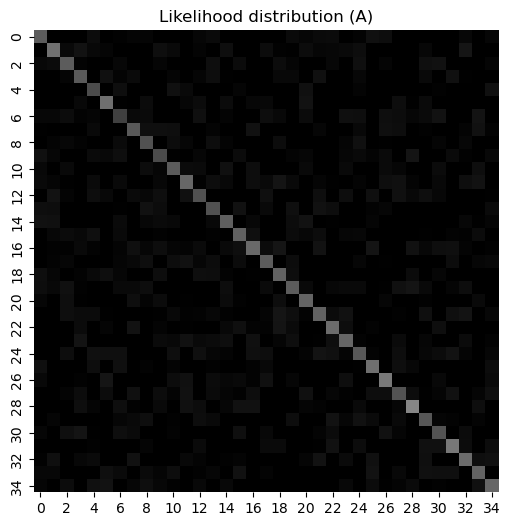

In [181]:
plot_likelihood((A[0]))

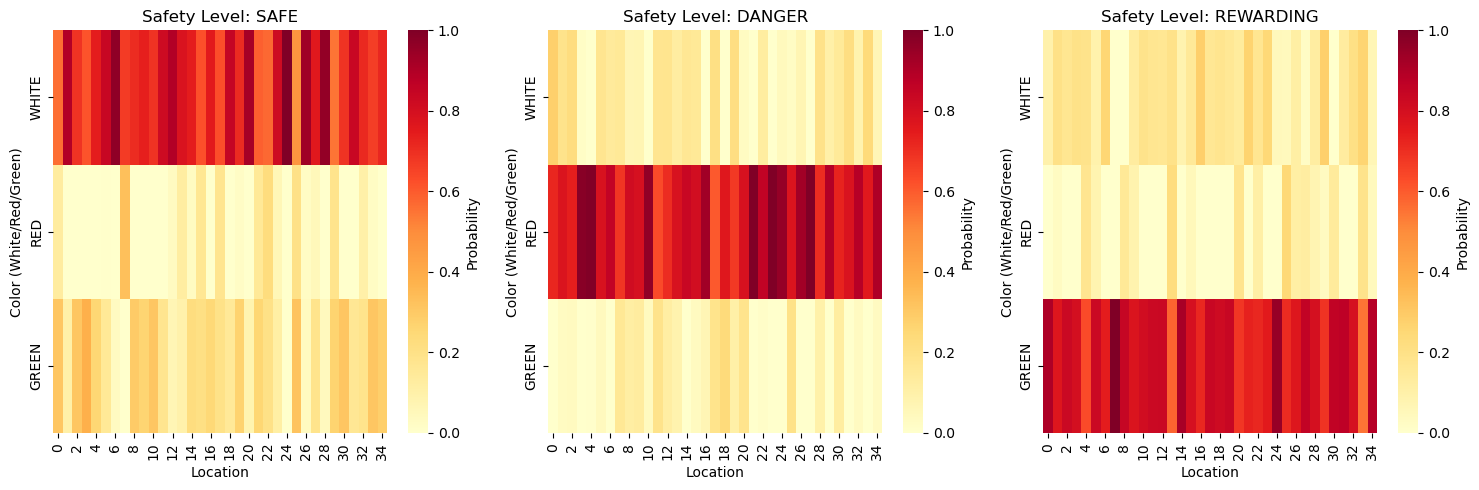

In [182]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
safety_labels = ['SAFE', 'DANGER', 'REWARDING']

# Plot each safety level separately
for i in range(3):  # 3 safety levels
    # Extract the matrix for this safety level
    safety_matrix = A[1][:, :, i]  # shape: (3 colors, 35 locations)
    
    # Create heatmap
    sns.heatmap(safety_matrix, 
                ax=axes[i],
                cmap='YlOrRd',
                vmin=0,
                vmax=1,
                cbar_kws={'label': 'Probability'})
    
    # Customize the plot
    axes[i].set_title(f'Safety Level: {safety_labels[i]}')
    axes[i].set_xlabel('Location')
    axes[i].set_ylabel('Color (White/Red/Green)')
    axes[i].set_yticks([0.5, 1.5, 2.5])
    axes[i].set_yticklabels(['WHITE', 'RED', 'GREEN'])

plt.tight_layout()
plt.show()

### B Array

In [183]:
num_controls = [5, 1]
B_f_shapes = [ [ns, ns, num_controls[f]] for f, ns in enumerate(num_states)]
B = utils.obj_array_zeros(B_f_shapes)
B_f_shapes


[[35, 35, 5], [3, 3, 1]]

In [184]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

# Populate matrix
for action_id, action_label in enumerate(actions):

  for curr_state, grid_location in enumerate(grid_locations):

    y, x = grid_location

    if action_label == "UP":
      next_y = y - 1 if y > 0 else y 
      next_x = x

    elif action_label == "DOWN":
      next_y = y + 1 if y < (grid_dims[0]-1) else y 
      next_x = x
      
    elif action_label == "LEFT":
      next_x = x - 1 if x > 0 else x 
      next_y = y
    elif action_label == "RIGHT":
      next_x = x + 1 if x < (grid_dims[1]-1) else x 
      next_y = y
    elif action_label == "STAY":
      next_x = x
      next_y = y

    new_location = (next_y, next_x)
    next_state = grid_locations.index(new_location)
    B[0][next_state, curr_state, action_id] = 1.0

In [185]:
# Initialize safety level transition matrix (no changes for safety levels)
B[1][:,:,0] = np.eye(3)  # Identity matrix for safety level transitions

# Normalize B matrix columns for each action
for action_id in range(len(actions)):
    # Get slice for current action
    B_action = B[0][..., action_id]
    
    # Replace zero columns with ones in appropriate positions
    zero_cols = (B_action.sum(axis=0) == 0)
    for col in range(B_action.shape[1]):
        if zero_cols[col]:
            # Stay in the same state if no transition is defined
            B_action[col, col] = 1.0
    
    # Normalize columns
    column_sums = B_action.sum(axis=0)
    B[0][..., action_id] = B_action / column_sums[None, :]

# Verify normalization
for action_id in range(len(actions)):
    assert np.allclose(B[0][..., action_id].sum(axis=0), 1.0), f"Action {actions[action_id]} not normalized"

### C Vectors (prior preferences)

In [186]:
# white, red, green

In [187]:
C = utils.obj_array_zeros(num_obs)  # Initialize C array with shape matching num_obs
print(C.shape)

# Set preferences for state observations (location)
C[0] = np.zeros(len(grid_locations))
print(C[0])

# Set preferences for color observations
C[1] = np.zeros((3,))  # 3 colors: red, green, white
C[1][1] = -1.0 
C[1][2] = 1.0 

print(C[1])


(2,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0. -1.  1.]


### D Vectors: Prior over (initial) hidden states

In [188]:
num_states

[35, 3]

In [189]:
# D = utils.obj_array_zeros(num_states)

# # Define agent's initial location
# agent_initial_state = grid_locations.index(agent_pos)  # Get index of agent's starting position
# D[0][agent_initial_state] = 1.0  # One-hot encoding

# # Define prior belief about safety levels
# D[1] = np.array([0.7, 0.2, 0.1])  # Higher probability for SAFE
# D[1] /= D[1].sum()  # Normalize to ensure it sums to 1

# # Verify the D matrix
# print("D[0] (Agent's location prior):\n", D[0])
# print("D[1] (Safety levels prior):\n", D[1])

# D.shape

In [190]:
D = utils.obj_array_uniform(num_states)

# Define prior belief about agent's location (same as before)
D[0] = np.zeros(num_states[0])  # Shape (35,)
agent_initial_state = grid_locations.index(agent_pos)
D[0][agent_initial_state] = 1.0  # One-hot encoding for location

# Define prior belief about attributes for EACH location
D[1] = np.zeros((num_states[0], num_states[1]))  # Shape (35, 3)

# Assign probabilities to attributes for each location
for loc in range(num_states[0]):
    # Example: Assume all locations have [SAFE: 0.7, DANGER: 0.2, REWARDING: 0.1]
    D[1][loc] = np.array([0.7, 0.2, 0.1])

    # Normalize each location's attribute distribution (ensure sum = 1)
    D[1][loc] /= D[1][loc].sum()

# Verify D matrix shapes
print("D[0] shape (Location prior):", D[0].shape)  # (35,)
print("D[1] shape (Attribute prior for all locations):", D[1].shape)  # (35, 3)

D.shape, D[0].shape, D[1].shape

D[0] shape (Location prior): (35,)
D[1] shape (Attribute prior for all locations): (35, 3)


((2,), (35,), (35, 3))

# Generative Process

In [191]:
def update_vision(current_location, grid_dims, distance):
    """
    Update the agent's field of vision based on the current location and distance
    Returns a list of all grid positions within the vision range
    
    Args:
        current_location (tuple): Current (y,x) position of the agent
        grid_dims (list): Dimensions of the grid [height, width]
        distance (int): Vision range/distance
        
    Returns:
        list: List of (y,x) tuples representing visible grid positions
    """
    y, x = current_location
    y_min = max(0, y - distance)
    y_max = min(grid_dims[0], y + distance + 1)
    x_min = max(0, x - distance)
    x_max = min(grid_dims[1], x + distance + 1)
    
    visible_locations = []
    for y_pos in range(y_min, y_max):
        for x_pos in range(x_min, x_max):
            visible_locations.append((y_pos, x_pos))
            
    return visible_locations

In [192]:
X, Y = 0, 0

class GridWorldEnv():

    def __init__(self, starting_loc = (0, 0), red1_loc = (1, 2), red2_loc = (3,2), red3_loc = (4,4), red4_loc = (6, 1), goal = (6 ,4)):
        self.init_loc = starting_loc
        self.current_location = self.init_loc
        Y, X = self.current_location

        self.red1_loc = red1_loc
        self.red2_loc = red2_loc
        self.red3_loc = red3_loc
        self.red4_loc = red4_loc
        self.redspots = [self.red1_loc, self.red2_loc, self.red3_loc, self.red4_loc]

        self.goal = goal

        self.red_obs = ['Null']
        self.green_obs = ['Null']
        self.white_obs = ['Null']

        self.agent_reward = 0 # not observation or state
        
        print(f"Starting location is {self.init_loc} | Red spot locations are {self.red1_loc, self.red2_loc, self.red3_loc, self.red4_loc} | Goal is {self.goal}")
    
    #Iteration of ActInf
    def step(self, action_label):

        Y, X = self.current_location


        if action_label == "UP": 
          if Y < grid_dims[0] - 1: Y_new = Y + 1
          else: Y_new = Y
          X_new = X

        elif action_label == "DOWN": 
        
          if Y > 0: Y_new = Y - 1
          else: Y_new = Y
          X_new = X      

        elif action_label == "LEFT": 
          
          if X > 0: X_new = X - 1
          else: X_new = X
          Y_new = Y

        elif action_label == "RIGHT": 
          
          if X < grid_dims[1] - 1: X_new = X + 1
          else: X_new = X
          Y_new = Y

        elif action_label == "STAY":
          Y_new, X_new = Y, X
        
        X, Y = X_new, Y_new
        self.current_location = (Y_new, X_new) # store the new grid location
        print(f" self.current_location: {self.current_location}")
        self.vision = update_vision(self.current_location, grid_dims, 6)

        self.loc_obs = self.current_location # agent directly observes its position in grid

        for spot in self.vision:
            if spot in self.redspots:
                if 'Null' in self.red_obs:
                    self.red_obs = [spot]
                else:
                    self.red_obs.append(spot)
            elif spot == self.goal:
                self.green_obs = [spot]
            else:
                if 'Null' in self.white_obs:
                    self.white_obs = [spot]
                else:
                    self.white_obs.append(spot)


        if self.current_location in self.redspots:
            self.agent_reward -= 5
            if 'Null' in self.red_obs:
                self.red_obs = [self.current_location]
            else:
                self.red_obs.append(self.current_location)
        elif self.current_location == self.goal:
            self.agent_reward += 20
            self.green_obs = [self.current_location]
        else:
            if 'Null' in self.white_obs:
                self.white_obs = [self.current_location]
            else:
                self.white_obs.append(self.current_location)
        
        return self.agent_reward, self.loc_obs, self.green_obs, self.white_obs, self.red_obs
    
    #Reset agent observations and reward
    def reset(self):
        self.current_location = self.init_loc
        print(f'Re-initialized location to {self.init_loc}')
        self.loc_obs = self.current_location
        self.green_obs, self.white_obs, self.red_obs, self.agent_reward = ['Null'], ['Null'], ['Null'], 0

        return self.loc_obs, self.green_obs, self.white_obs, self.red_obs, self.agent_reward

# Active Inference

## Define Agent

In [193]:
from pymdp.agent import Agent

In [194]:
my_agent = Agent(A = A, B = B, C = C, D = D, policy_len = 4) #form Agent with Agent class

my_env = GridWorldEnv(starting_loc = (0, 0), red1_loc = (1, 2), red2_loc = (3,2), red3_loc = (4,4), red4_loc = (6, 1), goal = (6 ,4)) #Define environment

loc_obs, green_obs, white_obs, red_obs, agent_reward = my_env.reset() #initialize observations

AssertionError: Check D vector: number of entries of D vector for factor 1 should be equal to 3

In [100]:
loc_obs, green_obs, white_obs, red_obs, agent_reward

((0, 0), ['Null'], ['Null'], ['Null'], 0)

## Create Observation Function

In [101]:
# def create_current_loc_observation(loc_obs, grid_locations):
#     """
#     Create a single observation vector from the individual components
#     Will be added to agent's belief about its current_location
#     """

#     return [grid_locations.index(loc_obs), None]

def create_current_loc_observation(loc_obs, grid_locations):
    """
    Create a single observation vector for the current location.
    """
    loc_index = grid_locations.index(loc_obs)
    loc_vector = [0] * len(grid_locations)
    loc_vector[loc_index] = 1  # Set the current location to 1 (one-hot encoding)
    return loc_vector  # Length 35 vector for location modality

In [102]:
create_current_loc_observation(loc_obs, grid_locations)

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [103]:
# def create_color_observation(position, red_obs, green_obs, white_obs):
#     """
#     Create a single observation vector from the individual components
#     Will be added to agent's belief about the color of the current_location
#     """

#     if position in red_obs: return [None, color.index('RED')]
#     elif position in green_obs: return [None, color.index('GREEN')]
#     elif position in white_obs: return [None, color.index('WHITE')]
#     return [None, None]

def create_color_observation(position, red_obs, green_obs, white_obs):
    """
    Create a single observation vector for the color of the current location.
    """
    color_vector = [0] * 3  # Length 3 vector for color modality (RED, GREEN, WHITE)
    if position in red_obs:
        color_vector[0] = 1  # RED
    elif position in green_obs:
        color_vector[1] = 1  # GREEN
    elif position in white_obs:
        color_vector[2] = 1  # WHITE
    return color_vector

In [104]:
for position in grid_locations: #iterate over position in grid
    color_observation = create_color_observation(position, red_obs, green_obs, white_obs) #create observation about color (red,green,white)
    print(color_observation)

[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]


## Loop

In [ ]:
history_of_locs = [loc_obs]

T = 15

for t in range(T):

    # Observation about current_location
    obs = create_current_loc_observation(loc_obs, grid_locations)
    qs[0] = my_agent.infer_states(obs)
    plot_beliefs(qs[0]) # qs[0] = first modality for grid locations

    # Color Observations
    for position in grid_locations:
        color_observation = create_color_observation(position, red_obs, green_obs, white_obs)
        if color_observation == [None, None]: continue
        qs[1] = my_agent.infer_states(color_observation)
        plot_beliefs(qs[1]) # qs[1] = second modality for attributes

    #Sample and Choose Action
    my_agent.infer_policies()
    chosen_action_id = my_agent.sample_action()

    movement_id = int(chosen_action_id[0])

    choice_action = actions[movement_id]

    print(f'Action at time {t}: {choice_action}')

    agent_reward, loc_obs, green_obs, white_obs, red_obs = my_env.step(choice_action)
    
    print(agent_reward, loc_obs, green_obs, white_obs, red_obs)


    history_of_locs.append(loc_obs)

    print(f'Grid location at time {t}: {loc_obs}')

    print(f'Reward at time {t}: {agent_reward}')

ValueError: operands could not be broadcast together with shapes (35,) (35,3) 